In [1]:
import numpy as np
import pandas as pd
import math
import time
from scipy.stats import laplace
from multiprocessing.pool import ThreadPool
from matplotlib import pyplot as plt

# Pré-processamento do dataset

In [2]:
def preProcessamento(dataset):
    return np.array(dataset)

# Funções de consultas

In [3]:
def Q1(dataset):    
    return np.mean(dataset[:,0])

In [4]:
def Q2(dataset):
    return np.sum(dataset[:,10])

In [5]:
def Q3(dataset):
    return np.mean(dataset[:,12])

In [6]:
def Q4(dataset):
    contIncome50k = 0
    for registro in dataset:
        if(registro[14] == '>50K'):
            contIncome50k = contIncome50k + 1
    return contIncome50k

# Obtenção da sensibilidade global de todas as funções de consulta

In [7]:
def sensibilidadeGlobal(consultas, dataset):
    sensibilidades = np.zeros(len(consultas)).tolist()
    respostasConsultas = []
    for consulta in consultas:
        respostasConsultas.append(consulta(dataset))
    for registro in range(0, dataset.shape[0]):
        datasetVizinho = np.copy(dataset)
        datasetVizinho = np.delete(datasetVizinho, registro, 0)
        for i in range(0, len(consultas)):
            respostaVizinho = consultas[i](datasetVizinho)
            sens = abs(respostasConsultas[i] - respostaVizinho)
            if(sens >= sensibilidades[i]):
                sensibilidades[i] = sens
            time.sleep(0.00001)
    return sensibilidades

In [8]:
def sensibilidadeGlobalMult(consultas, dataset):
    pool = ThreadPool(processes = 100)
    async_call = pool.apply_async(sensibilidadeGlobal, (consultas, dataset, ))
    return async_call.get()

In [9]:
def adquirirSensibilidades(consultas, dataset):
    sensibilidades = sensibilidadeGlobalMult(consultas, dataset)
    return sensibilidades

# Geração da resposta com ruído

In [10]:
def respostaRuido(budget, sensibilidade, funcaoConsulta, dataset):
    respostaConsulta = funcaoConsulta(dataset)
    probOriginal = laplace.pdf(0, loc = 0, scale = sensibilidade/budget)
    privacidade = False
    respostaRuido = 0
    np.random.seed(0)
    while(not privacidade):
        ruido = laplace.rvs(loc = 0, scale = sensibilidade/budget)
        resposta = respostaConsulta + ruido
        probRuido = laplace.pdf(ruido, loc = 0, scale = sensibilidade/budget)
        if(probOriginal <= (math.e**budget)*probRuido):
            privacidade = True
            respostaRuido = resposta
    return respostaRuido

# Gerar CSV

In [11]:
def posProcessamento(budgets, respostas, sensibilidades):
    datasetFinal = []
    for i in range(0, len(budgets)):
        registro = [budgets[i]]
        for j in range(0, len(respostas[i])):
            registro.append(respostas[i][j])
        for j in range(0, len(sensibilidades)):
            registro.append(sensibilidades[j])
        datasetFinal.append(registro)
    datasetFinal = pd.DataFrame(datasetFinal, columns=['budget', 'result_q1', 'result_q2', 'result_q3', 'result_q4', 
                                                       'sens _q1', 'sens_q2', 'sens_q3', 'sens_q4'])
    arquivo = 'result.csv'
    datasetFinal.to_csv(arquivo, index=False)

# Execução

In [12]:
dataset = pd.read_csv('adult.csv')
dataset = preProcessamento(dataset)

In [13]:
consultas = [Q1, Q2, Q3, Q4]
budgets = [0.1, 1, 10]
sensibilidades = adquirirSensibilidades(consultas, dataset)

In [14]:
respostas = []
for budget in budgets:
    respostaBudget = []
    for i in range(0, len(consultas)):
        np.random.seed()
        resposta = respostaRuido(budget/len(consultas), sensibilidades[i], consultas[i], dataset)
        respostaBudget.append(resposta)
    respostas.append(respostaBudget)
posProcessamento(budgets, respostas, sensibilidades)

In [15]:
for i in range(0, len(budgets)):
    for j in range(0, len(consultas)):
        print('Budget:', budgets[i])
        print('Consulta: Q'+str(j+1))
        print('Sensibilidade:', sensibilidades[j])
        print('Resposta Original:', consultas[j](dataset))
        print('Resposta + Ruído:', respostas[i][j],'\n')

Budget: 0.1
Consulta: Q1
Sensibilidade: 4.5636285693984036e-05
Resposta Original: 1.7710781704270915
Resposta + Ruído: 1.7710830120318177 

Budget: 0.1
Consulta: Q2
Sensibilidade: 4
Resposta Original: 9784
Resposta + Ruído: 9784.42436448564 

Budget: 0.1
Consulta: Q3
Sensibilidade: 4.19586378328507e-05
Resposta Original: 1.9506981696081243
Resposta + Ruído: 1.9507026210470648 

Budget: 0.1
Consulta: Q4
Sensibilidade: 1
Resposta Original: 11687
Resposta + Ruído: 11687.10609112141 

Budget: 1
Consulta: Q1
Sensibilidade: 4.5636285693984036e-05
Resposta Original: 1.7710781704270915
Resposta + Ruído: 1.7710969228017759 

Budget: 1
Consulta: Q2
Sensibilidade: 4
Resposta Original: 9784
Resposta + Ruído: 9785.64363724165 

Budget: 1
Consulta: Q3
Sensibilidade: 4.19586378328507e-05
Resposta Original: 1.9506981696081243
Resposta + Ruído: 1.950715410803062 

Budget: 1
Consulta: Q4
Sensibilidade: 1
Resposta Original: 11687
Resposta + Ruído: 11687.410909310413 

Budget: 10
Consulta: Q1
Sensibilidad

# Visualização das distribuições

In [16]:
deltas = []
for i in range(0, len(consultas)):
    deltaConsulta = []
    for j in range(0, len(budgets)):
        deltaConsulta.append(sensibilidades[i]/(budgets[j]/len(consultas)))
    deltas.append(deltaConsulta)
print(deltas)

[[0.0018254514277593614, 0.00018254514277593614, 1.8254514277593613e-05], [160.0, 16.0, 1.6], [0.001678345513314028, 0.0001678345513314028, 1.678345513314028e-05], [40.0, 4.0, 0.4]]


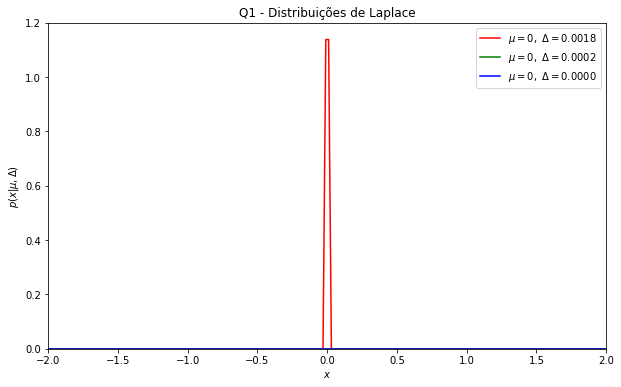

In [17]:
cores = ['red', 'green', 'blue']
media = 0
x = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots(figsize=(10, 6))

for delta, cor in zip(deltas[0], cores):
    dist = laplace(media, delta)
    
    plt.plot(x, dist.pdf(x), ls='-', c=cor, label=r'$\mu=%i,\ \Delta=%.4f$' % (media, delta))

plt.xlim(-2, 2)
plt.ylim(0, 1.2)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Q1 - Distribuições de Laplace')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

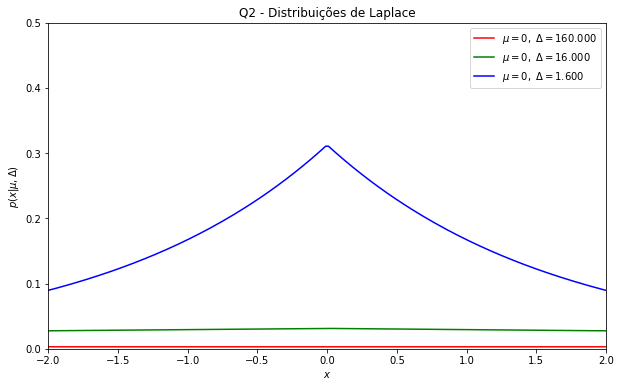

In [18]:
cores = ['red', 'green', 'blue']
media = 0
x = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots(figsize=(10, 6))

for delta, cor in zip(deltas[1], cores):
    dist = laplace(media, delta)
    
    plt.plot(x, dist.pdf(x), ls='-', c=cor, label=r'$\mu=%i,\ \Delta=%.3f$' % (media, delta))

plt.xlim(-2, 2)
plt.ylim(0, 0.5)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Q2 - Distribuições de Laplace')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

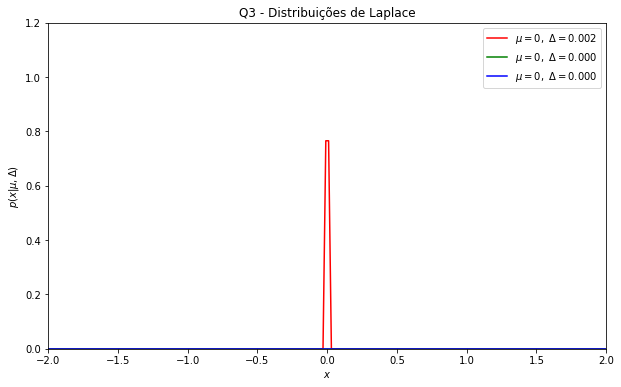

In [19]:
cores = ['red', 'green', 'blue']
media = 0
x = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots(figsize=(10, 6))

for delta, cor in zip(deltas[2], cores):
    dist = laplace(media, delta)
    
    plt.plot(x, dist.pdf(x), ls='-', c=cor, label=r'$\mu=%i,\ \Delta=%.3f$' % (media, delta))

plt.xlim(-2, 2)
plt.ylim(0, 1.2)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Q3 - Distribuições de Laplace')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()

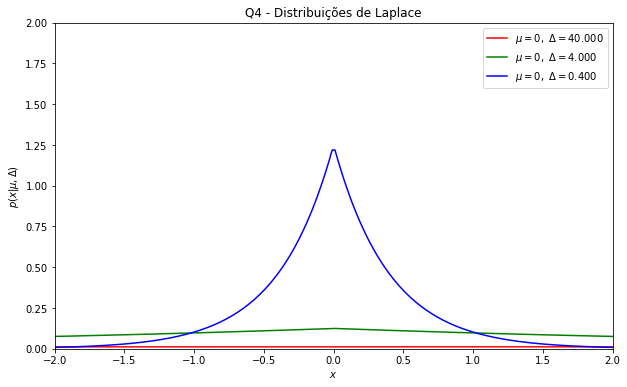

In [20]:
cores = ['red', 'green', 'blue']
media = 0
x = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots(figsize=(10, 6))

for delta, cor in zip(deltas[3], cores):
    dist = laplace(media, delta)
    
    plt.plot(x, dist.pdf(x), ls='-', c=cor, label=r'$\mu=%i,\ \Delta=%.3f$' % (media, delta))

plt.xlim(-2, 2)
plt.ylim(0, 2)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Q4 - Distribuições de Laplace')

plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()